In [1]:
import numpy as np
import pandas as pd
import pydeck as pdk
import matplotlib.pyplot as plt

## Get Integrated NPP DataFrame

Bottle Database: https://calcofi.org/data/oceanographic-data/bottle-database/

In [2]:
data = pd.read_csv('../data/194903-202105_Bottle.csv', encoding='ISO-8859-1', low_memory=False)
metadata = pd.read_csv('../data/194903-202105_Cast.csv', encoding='ISO-8859-1', low_memory=False)

# Subset to only productivity casts
data = data[data['Depth_ID'].str.contains('PR')]

In [3]:
bottle_data = data[['Sta_ID', 'Depth_ID', 'Depthm', 'MeanAs']].copy()

# Function to extract the date and time from Depth_ID
# Uses the Cast_ID prefix ([Century]-[Year][Month][ShipCode]-[CastType][Julian Day]-[CastTime]-[Line][Sta]) 
# but adds three additional variables: [Depth][Bottle]-[Rec_Ind]
def extract_datetime(depth_id):
    # Extract year, month, and cast time
    year = depth_id.split('-')[0] +  depth_id.split('-')[1][:2]
    month = depth_id.split('-')[1][2:4]
    julianday = depth_id.split('-')[3]
    casttime = depth_id.split('-')[4]
    castid = "-".join(depth_id.rsplit("-", 2)[:-2])
    
    return pd.Series([year, month, julianday, casttime, castid], index=['Year', 'Month', 'JulianDay', 'CastTime', 'Cast_ID'])

# Apply the function to the Depth_ID column
bottle_data[['Year', 'Month', 'JulianDay', 'CastTime', 'Cast_ID']] = bottle_data.loc[:,'Depth_ID'].apply(extract_datetime)

# Function to convert Year, Month, JulianDay to Date
def create_date(year, month, julian_day):
    # Create the date using the Julian day and the year
    date = pd.to_datetime(f'{year}-{month}-01') + pd.to_timedelta(int(julian_day) - 1, unit='D')
    return date

# Function to format CastTime to a time column
def create_time(casttime):
    # CastTime format is HHMM (e.g., 1806 -> 18:06)
    if pd.isna(casttime):
        return None  # If there's no time, return None
    time = f'{str(casttime)[:2]}:{str(casttime)[2:]}'
    return time

# Apply the functions to the dataframe
bottle_data['Date'] = bottle_data.apply(lambda row: create_date(row['Year'], row['Month'], row['JulianDay']), axis=1)
bottle_data['Time'] = bottle_data['CastTime'].apply(create_time)

# Show the updated dataframe
bottle_data = bottle_data.drop(columns=['Year', 'Month', 'JulianDay', 'CastTime'])
bottle_data = bottle_data[['Sta_ID', 'Depth_ID', 'Cast_ID', 'Date', 'Time', 'Depthm', 'MeanAs']]
bottle_data = bottle_data.reset_index(drop=True)

In [4]:
# Calculate the depth-integrated primary productivity
grouped = bottle_data.groupby(['Sta_ID', 'Cast_ID', 'Date', 'Time'])

def calculate_depth_integrated(group):
    group = group.sort_values(by='Depthm')
    group = group.dropna(subset=['MeanAs', 'Depthm'])
    
    # Calculate area under curve using np.trapezoid
    area = np.trapz(group['MeanAs'], group['Depthm'])
    return area

npp = pd.DataFrame(grouped.apply(calculate_depth_integrated, include_groups=False))
npp = npp.reset_index()
npp = npp.merge(metadata[['Cast_ID', 'Lat_Dec', 'Lon_Dec']], on='Cast_ID')
npp.columns = ['Sta_ID', 'Cast_ID', 'Date', 'Time', 'Integrated_NPP_HalfDay', 'Latitude', 'Longitude']
npp['Integrated_NPP'] = npp['Integrated_NPP_HalfDay'] * 1.8
npp = npp[['Sta_ID', 'Cast_ID', 'Date', 'Time', 'Latitude', 'Longitude', 'Integrated_NPP_HalfDay', 'Integrated_NPP']]

In [5]:
#npp.to_csv('CalCOFI_Integrated_NPP.csv')

## Load Integrated NPP Data

In [ ]:
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp

In [6]:
# Visualize Integrated NPP
vis = npp.copy()
vis['Sta_ID'] = vis['Sta_ID'].astype(str)
vis[['Latitude', 'Longitude', 'Integrated_NPP']] = vis[['Latitude', 'Longitude', 'Integrated_NPP']].astype(float)
vis['Color'] = [[200, int(255 * (val / 1000)), 100] for val in vis["Integrated_NPP"]]
vis = vis.to_dict(orient='records')

scatter_layer = pdk.Layer(
    "ScatterplotLayer",
    vis,
    get_position=["Longitude", "Latitude"],
    get_fill_color="Color",  # Adjust color based on NPP
    radius_min_pixels=5,
    radius_max_pixels=50,
    pickable=True,
)

# Define the Pydeck View
view_state = pdk.ViewState(
    latitude=npp["Latitude"].mean(),
    longitude=npp["Longitude"].mean(),
    zoom=4,
    pitch=0
)

# Create the Pydeck Deck
deck = pdk.Deck(
    layers=[scatter_layer],
    initial_view_state=view_state,
    tooltip={"text": "{Sta_ID}\nNPP: {Integrated_NPP}"}
)
deck.show()

(0.0, 2000.0)

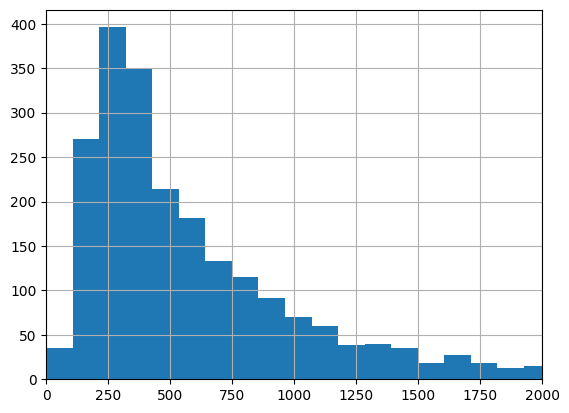

In [7]:
fig, ax = plt.subplots()
npp['Integrated_NPP'].hist(ax=ax, bins=100)
ax.set_xlim(0,2000)